In [1]:
import os
import scipy
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from single_photons.simulation.simulation_particle import simulation_p
import single_photons.utils.constants as ct
from single_photons.environment import Particle
from single_photons.utils.parameters import *
from single_photons.utils.metrics import *
from control import dare
from tqdm import tqdm

C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['figure.dpi'] = 200#600
C = ['#2E86C1', '#85C1E9', '#1B4F72']

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
basic_bool = 1
trajectory_bool = 0
numbers_acquire_bool = 0
numbers_process_bool = 0

main = os.getcwd()

delta_t = 4e-10
control_step = int(32e-9/delta_t)
omega = 2*np.pi*104e3
period = 2*np.pi/omega
t = np.arange(0, 1000 * period, delta_t)
N = t.shape[0]
g_fb_ratio = [1e3/omega, 1.05]

p = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
waist = 3.7352e-6 #from scattered power in Magrini paper. resulting theoretical omega is 56% the experimental one
eta_detection = 0.80 #0.178
fs = 1/(control_step*delta_t)

In [7]:
gamma, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, omega,
                                                                      radius, p, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
env = Particle(omega, gamma, coupling, eta_detection=eta_detection, radius = radius)
std_detection = std_detection/env.zp_x
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0],
                        [0, omega/2]])

g_fb = g_fb_ratio[0]*omega
r = omega/g_fb**2
X, L, G_fb = dare(Ad, Bd, cost_states, r)
if trajectory_bool:
    g_fb = g_fb_ratio[1]*omega
    r = omega/g_fb**2
    X, L, G_fb_1 = dare(Ad, Bd, cost_states, r)

In [8]:
x0 = std_detection
P0 = std_detection**2

if trajectory_bool or basic_bool:
    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_p(
        env.A,
        env.B, 
        env.thermal_force_std,
        env.backaction_std, 
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        G_fb,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

if trajectory_bool:
    new_states_1 , measured_states_1, estimated_states_1, cov_aposteriori_1, controls_1 = simulation_p(
        env.A,
        env.B, 
        env.thermal_force_std,
        env.backaction_std, 
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        G_fb_1,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:72: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:72: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))


In [6]:
if basic_bool:
    step=1000
    phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step=step)
    plt.plot(t[::control_step][::step][:phonons.shape[0]]/1e-6, phonons)
    #plt.xlim([t[::control_step][::step][1]/1e-6, t[::control_step][::step][-1]/1e-6])
    #plt.ylim([0,20])
    plt.ylabel(r'log$_{10}\langle \bar{n} \rangle$')
    plt.xlabel(r'$t[\mu s]$')
    plt.yscale('log')
    plt.grid()
    #plt.ylim([0,3])
    plt.show()

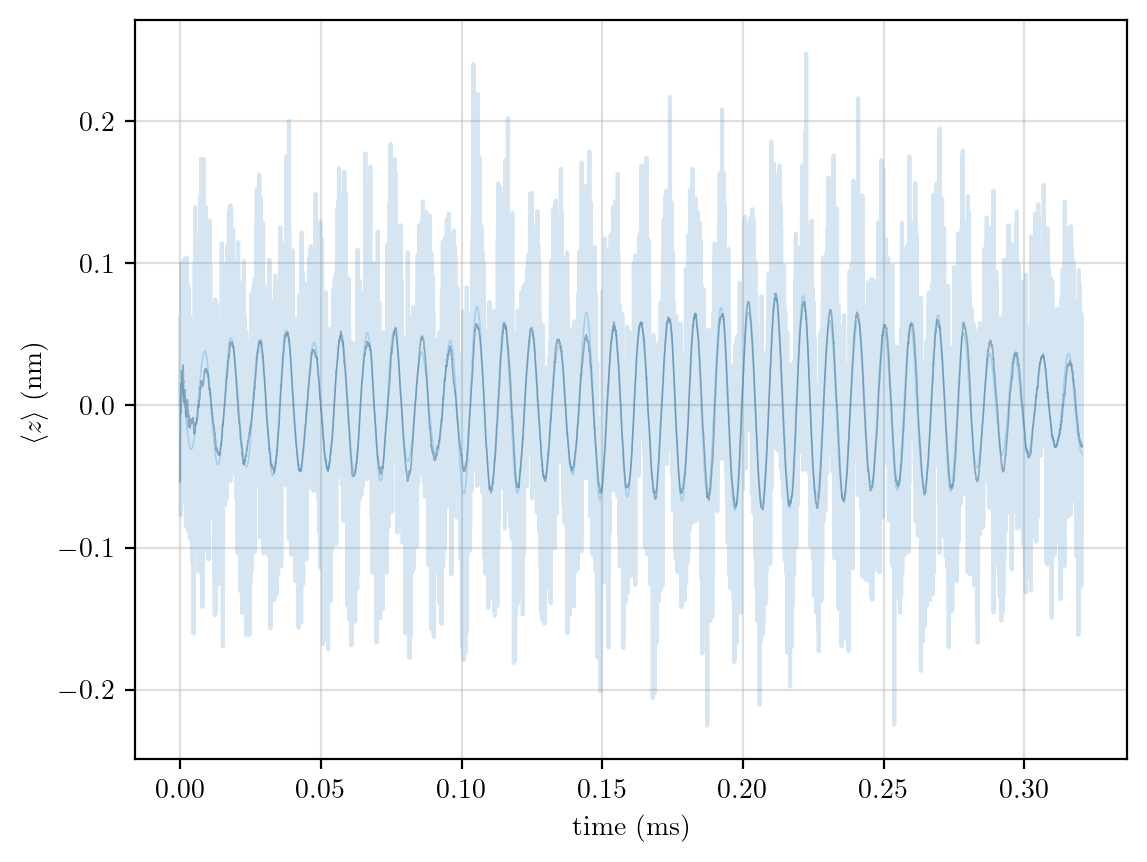

In [18]:
if basic_bool:
    plt.plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*measured_states[:int(N/30):control_step], color = C[0], alpha = 0.2)
    plt.plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*new_states[:int(N/30):control_step,0], color = C[1], alpha = 0.6, linewidth = 0.6)
    plt.plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*estimated_states[:int(N/30):control_step,0], color = C[2], alpha = 0.4, linewidth = 0.6)
    plt.ylabel(r'$\langle z \rangle$ (nm)')
    plt.xlabel(r'time (ms)')
    plt.grid(alpha = 0.4)

In [8]:
if trajectory_bool:
    df = pd.DataFrame()
    df['z'] = butter_bandpass_filter(estimated_states[:,0][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=2)[200:]
    df['p'] = butter_bandpass_filter(estimated_states[:,1][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=2)[200:]
    df[r'$g_{fb}$'] = len(df)*['8.32kHz']

    df_1 = pd.DataFrame()
    df_1['z'] = butter_bandpass_filter(estimated_states_1[:,0][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=2)[200:]
    df_1['p'] = butter_bandpass_filter(estimated_states_1[:,1][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=2)[200:]
    df_1[r'$g_{fb}$'] = len(df_1)*['109kHz']
    
    df = pd.concat([df,df_1])

In [9]:
if trajectory_bool:
    circle_r = 1/2
    d = np.linspace(0,2*np.pi,1600)
    x,y = circle_r*np.cos(d), circle_r*np.sin(d)
    n_0 = compute_phonons(estimated_states, cov_aposteriori, control_step, step=25)[-5:-1]
    n_1 = compute_phonons(estimated_states_1, cov_aposteriori_1, control_step, step=25)[-5:-1]
    sns.set_theme(style="white")
    sns.set_style("ticks",{'axes.grid' : False})
    g = sns.JointGrid(data=df, x="z", y="p", hue = r'$g_{fb}$', xlim=[-12,12], ylim=[-12,12],
                      space = 0, marginal_ticks = False, palette = 'colorblind')#sns.set_palette(C))
    g.plot_joint(sns.lineplot, sort = False, alpha = 0.7,linewidth = 0.1)
    g.set_axis_labels(r'$\langle z \rangle /z_{zp}$',r'$\langle p \rangle /p_{zp}$')
    plt.xticks(np.linspace(-10,10,5))
    plt.yticks(np.linspace(-10,10,5))
    g.plot_marginals(sns.kdeplot, alpha=0.5, fill=True)
    g.ax_joint.plot(x,y)
    text1 = r'$\langle n_{8.3} \rangle =$' + ' {:.2f}'.format(np.mean(n_0)) + r' $\pm$ ' + '{:.2f}'.format(np.std(n_0))
    text2 = r'$\langle n_{109} \rangle =$' + ' {:.2f}'.format(np.mean(n_1)) + r' $\pm$ ' + '{:.2f}'.format(np.std(n_1))
    plt.text(-0.64,-10.3,text1, color = sns.color_palette('colorblind')[0])
    plt.text(-0.65,-11.5,text2, color = sns.color_palette('colorblind')[1])
    plt.tight_layout()
    #plt.savefig('phase_space.pdf', dpi = 600)

In [10]:
if basic_bool:
    var_z = np.sqrt(cov_aposteriori[:,0,0])
    var_p = np.sqrt(cov_aposteriori[:,1,1])
    plt.plot(1e3*t[::control_step],std_z[:t[::control_step].shape[0]])
    plt.yscale('log')
    plt.ylabel(r'$\langle \bar{\sigma}_z \rangle / z_{zp}$')
    plt.xlabel(r'$t$ (ms)')
    plt.show()
    plt.figure()
    plt.plot(1e3*t[::control_step],std_p[:t[::control_step].shape[0]])
    plt.yscale('log')
    plt.ylabel(r'$\langle \bar{\sigma}_p \rangle / p_{zp}$')
    plt.show()

In [11]:
if numbers_acquire_bool:
    numbers_mean = []
    numbers_std = []
    x0 = std_detection
    P0 = std_detection**2
    g_fb_list = 2e3*np.pi*np.linspace(1,25,25)#np.concatenate((np.linspace(1.5,6,4),np.linspace(8,156,12)))
    for g in tqdm(g_fb_list):
        r = omega/g**2
        X, L, G_fb = dare(Ad, Bd, cost_states, r)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_p(
            env.A,
            env.B, 
            env.thermal_force_std,
            env.backaction_std, 
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            G_fb,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        n = compute_phonons(estimated_states, cov_aposteriori, control_step, step=350)[-20:-1]
        numbers_mean.append(np.mean(n))
        numbers_std.append(np.std(n))
    numbers_mean = np.array(numbers_mean)
    numbers_std = np.array(numbers_std)
    data = {'mean': numbers_mean,
           'std': numbers_std,
           'gain': g_fb_list,
           'eta': np.array(len(numbers_mean)*[eta_detection])}
    df = pd.DataFrame(data)
    if 'data_numbers.pkl' in os.listdir(main):
        df_main = pd.read_pickle('data_numbers.pkl')
        df = pd.concat([df_main,df])
    df.to_pickle('data_numbers.pkl')

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:72: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:72: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [13:39<00:00, 32.80s/it]


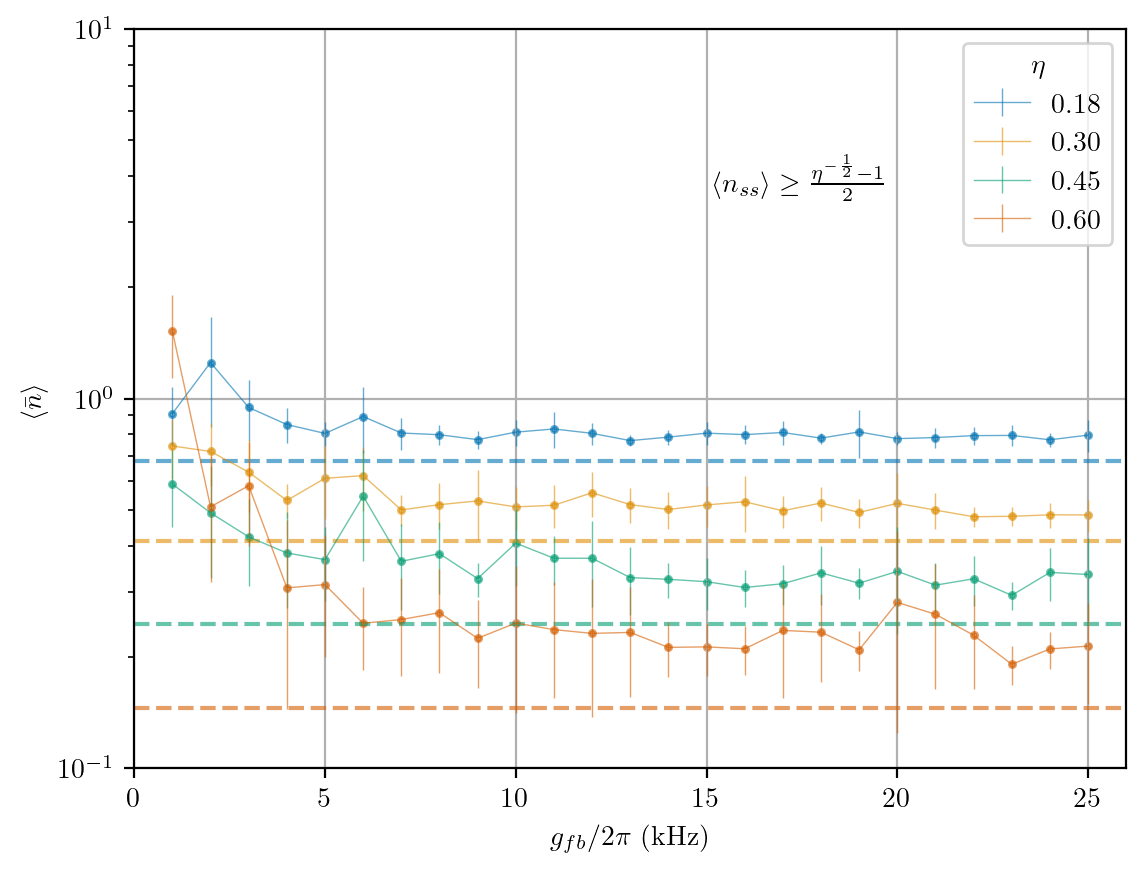

In [17]:
if numbers_process_bool:
    colors = sns.color_palette('colorblind')
    df = pd.read_pickle('data_numbers.pkl')
    etas = df['eta'].unique()
    line = []
    count = 0
    
    for el in etas:
        x = df[df['eta'] == el]['gain'].values
        y = df[df['eta'] == el]['mean'].values
        error = df[df['eta'] == el]['std'].values
        if el > 0.60:
            continue
        xmax = (x[0] + x[-1])/(2e3*np.pi)
        if count == 0:
            fig,ax = plt.subplots()
            ax.set_xlim(0, xmax)
            ax.set_ylim(0.1,10)
            ax.set_xlabel(r'$g_{fb}/2\pi$ (kHz)')
            ax.set_ylabel(r'$\langle \bar{n} \rangle$')
            ax.set_yscale('log')
            plt.text(15.2, 3.65, r'$\langle n_{ss} \rangle \geq \frac{\eta^{-\frac{1}{2}}-1}{2}$')
        plt.scatter(x/(2e3*np.pi),y, s = 5, color = colors[count], alpha = 0.6)
        line.append(ax.errorbar(x/(2e3*np.pi),y,error, color = colors[count], linewidth = 0.5, alpha = 0.6))
        line[-1].set_label('{:.2f}'.format(el))
        plt.plot([0, xmax], 2*[(1/np.sqrt(el) - 1)/2], linestyle = '--', color = colors[count], alpha = 0.6)
        count += 1
    ax.legend(title = r'$\eta$')
    plt.grid()
    plt.savefig('number_gain.pdf', dpi = 600)

In [21]:
a = [1,2,3]
print([*a])

[1, 2, 3]
